<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Поиндексовые-графики" data-toc-modified-id="Поиндексовые-графики-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Поиндексовые графики</a></span></li><li><span><a href="#Графики-сезонности-и-тренда" data-toc-modified-id="Графики-сезонности-и-тренда-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Графики сезонности и тренда</a></span></li><li><span><a href="#Тест-Дики-Фуллера" data-toc-modified-id="Тест-Дики-Фуллера-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Тест Дики-Фуллера</a></span></li></ul></li><li><span><a href="#Построение-моделей" data-toc-modified-id="Построение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#SARIMA" data-toc-modified-id="SARIMA-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SARIMA</a></span></li><li><span><a href="#Prophet" data-toc-modified-id="Prophet-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Prophet</a></span></li></ul></li><li><span><a href="#Построение-функции-для-прогнозирования-стабильной-части-для-заданной-даты-и-горизонта" data-toc-modified-id="Построение-функции-для-прогнозирования-стабильной-части-для-заданной-даты-и-горизонта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Построение функции для прогнозирования стабильной части для заданной даты и горизонта</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

Импортируем библиотеки.

In [142]:
import time
import warnings
import numpy as np
import pandas as pd
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import dates
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pmdarima
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from prophet import Prophet

warnings.filterwarnings("ignore")

Прочитаем данные с файла и сохраним в data.

In [58]:
data = pd.read_csv('data.csv', sep=';', parse_dates=[0], index_col=[0])

In [59]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-10-10
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-02-01,3417092149
2014-03-01,3417092149
2014-04-01,3417092149
2014-05-01,3417092149
2014-06-01,3320846785
2014-07-01,3320846785


Согласно документации к данным, в таблице `data` имеются следующие столбцы:
- `REPORTDATE`- дата
- `VALUE` - сумма на счете

Значение даты нужно будет привести к формату даты.

Проверим есть ли пропуски.

In [60]:
data.isna().sum()

VALUE    0
dtype: int64

Пропусков нет.

Отсортируем данные по дате.

In [61]:
data = data.sort_index()
data.head(10)

,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,4333581643
2014-01-03,5010720003
2014-01-04,5007552613
2014-01-05,16828540812
2014-01-06,17206823472
2014-01-07,17600814179


Проверим не нарушена ли хронологическая последовательность.

In [62]:
data.index.is_monotonic

True

Ресемплируем данные, сгруппируем данные на месячные интервалы и посмотрим на среднее значение накоплений на интервалах.

In [63]:
data = data.resample('M').mean()
data.head(10)

,VALUE
REPORTDATE,
2013-12-31,3.437359e+09
2014-01-31,7.303697e+09
2014-02-28,8.253378e+09
2014-03-31,8.363964e+09
2014-04-30,8.055626e+09
2014-05-31,1.526450e+10
2014-06-30,1.583219e+10
2014-07-31,1.710609e+10
2014-08-31,1.708165e+10


**Вывод этапа:**
- Загружены данные
- Исправлен тип данных даты
- Проведена проверка на пропуски и дубликаты в данных (не обнаружено)
- Проведено ресемплирование данных на месячные интервалы

## Анализ данных

Выводим графики средств на счетах клиентов, а также скользящее среднее с окном в месяц и год и полосы Боллинджера с доверительным 95%-м интервалом

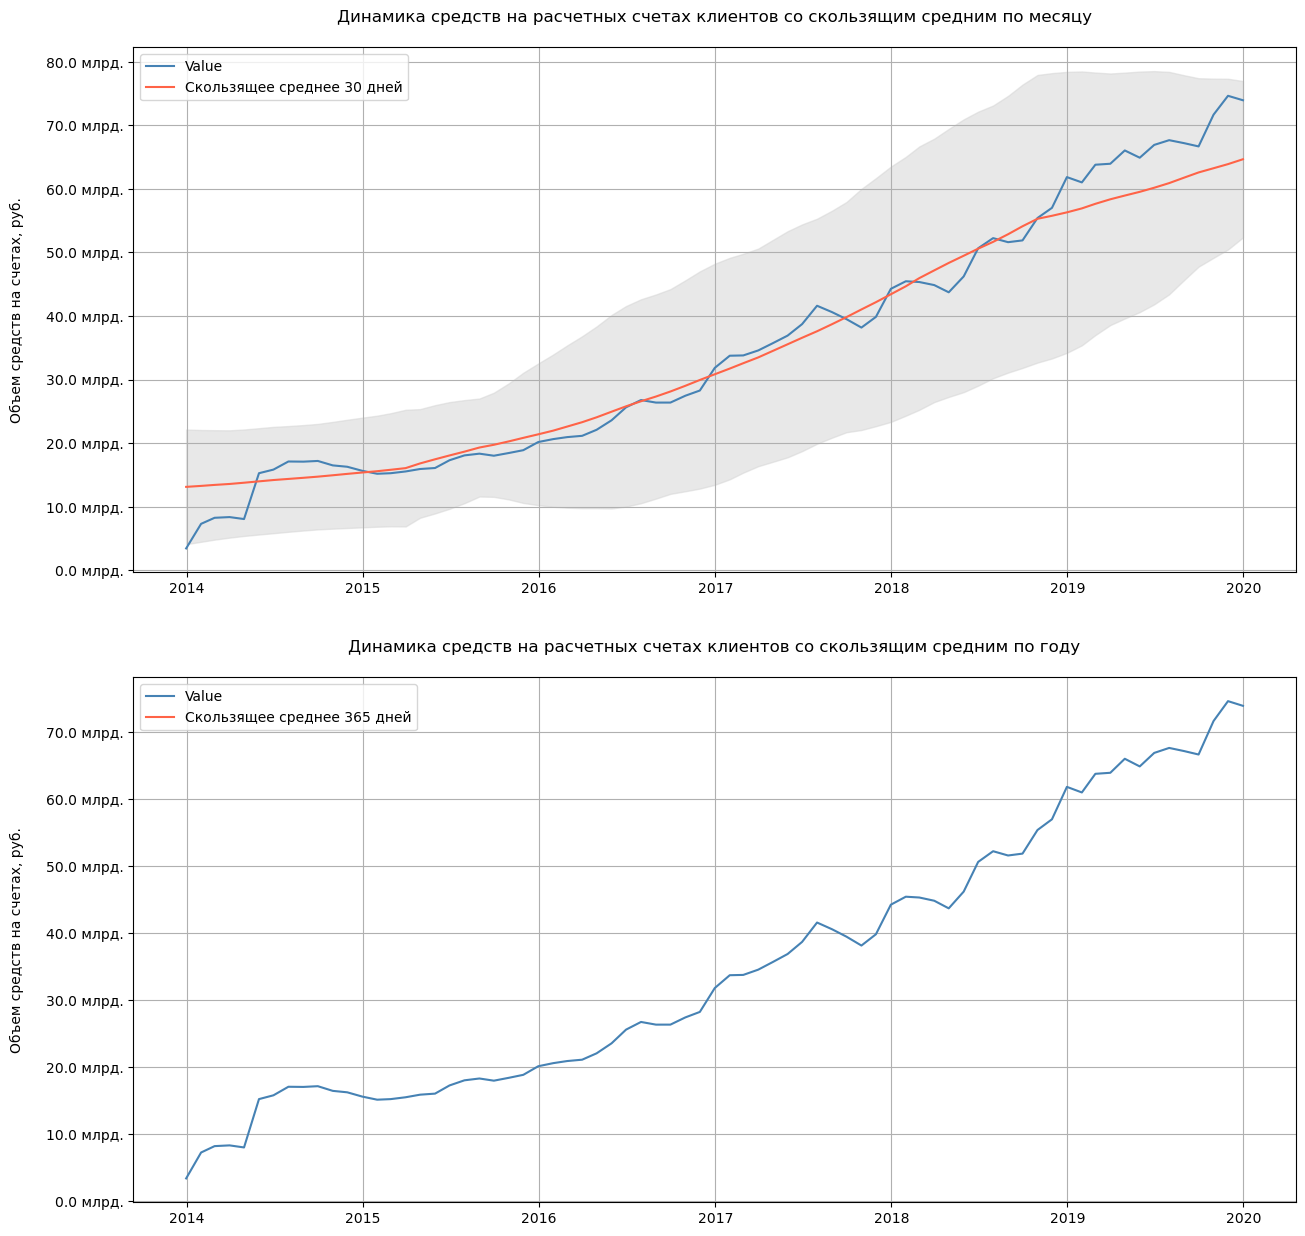

In [70]:
def billions(x, pos):
    return '%1.1f млрд.' % (x*1e-9)

formatter = FuncFormatter(billions)

ts = data.squeeze()
rolling_mean_month = ts.rolling(window=30, center=True, min_periods=15).mean()    
rolling_std_month = ts.rolling(window=30, center=True, min_periods=15).std()
lower_bound_month = rolling_mean_month - (1.96 * rolling_std_month)
upper_bound_month = rolling_mean_month + (1.96 * rolling_std_month)

rolling_mean_year = ts.rolling(window=365, center=True, min_periods=182).mean()    
rolling_std_year = ts.rolling(window=365, center=True, min_periods=182).std()
lower_bound_year = rolling_mean_year - (1.96 * rolling_std_year)
upper_bound_year = rolling_mean_year + (1.96 * rolling_std_year)

fig, ax = plt.subplots(2, 1, figsize=(15, 15))

ax[0].plot(ts, label='Value', color='steelblue')
ax[0].plot(rolling_mean_month, 'g', label='Скользящее среднее 30 дней', color='tomato')
ax[0].fill_between(x=ts.index, y1=lower_bound_month, y2=upper_bound_month, color='lightgrey', alpha=0.5)
ax[0].legend(loc='upper left')
ax[0].set_title('Динамика средств на расчетных счетах клиентов со скользящим средним по месяцу\n')
ax[0].set_ylabel('Объем средств на счетах, руб.\n')
ax[0].xaxis.set_major_locator(dates.AutoDateLocator())  
ax[0].yaxis.set_major_formatter(formatter)
ax[0].grid()

ax[1].plot(ts, label='Value', color='steelblue')
ax[1].plot(rolling_mean_year, 'g', label='Скользящее среднее 365 дней', color='tomato')
ax[1].fill_between(x=ts.index, y1=lower_bound_year, y2=upper_bound_year, color='lightgrey', alpha=0.5)
ax[1].legend(loc='upper left')
ax[1].set_title('Динамика средств на расчетных счетах клиентов со скользящим средним по году\n')
ax[1].set_ylabel('Объем средств на счетах, руб.\n')
ax[1].xaxis.set_major_locator(dates.AutoDateLocator())
ax[1].yaxis.set_major_formatter(formatter)
ax[1].grid();

Видим рост всех параметров.

Для более детального анализа необходимо построить поиндексовые графики количества заказов, а также графики сезонности, тренда и график разностного временного ряда.

При обучении и анализе нам понадобятся разделенные признаки данных, поэтому напишем функцию создания датафрейма с этими признаками.

In [81]:
def make_features(data, rolling_mean_size = 0, max_lag = 0):
    df = data.copy()
    df['day'] = df.index.day
    df['month'] = data.index.month
    df['dayofweek'] = df.index.dayofweek
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = data['VALUE'].shift(lag)
    df['rolling_mean'] = df['VALUE'].shift().rolling(rolling_mean_size).mean()
    return df

Посмотрим на графики автокорреляции и частичной автокорреляции 

### Поиндексовые графики     

Для построения графиков понадобятся календарные индексы, создадим датафрейм с признаками.

In [82]:
df = make_features(data)

**График по месяцам**

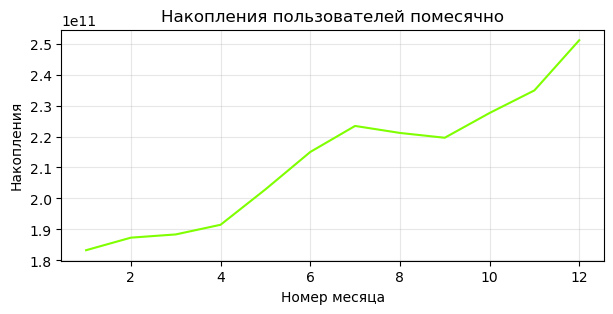

In [83]:
df.groupby('month')['VALUE'].sum().plot(figsize=(7, 3), color='chartreuse')
plt.xlabel('Номер месяца')
plt.ylabel('Накопления')
plt.title('Накопления пользователей помесячно')
plt.grid(axis='both', alpha=.3)

Видно возратание количества накоплений течении года.

**График по дням недели**

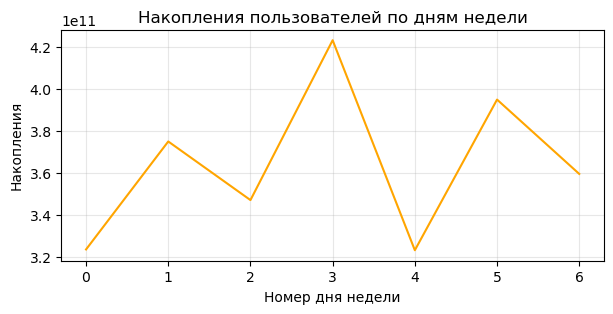

In [84]:
df.groupby('dayofweek')['VALUE'].sum().plot(figsize=(7, 3), color='orange')
plt.xlabel('Номер дня недели')
plt.ylabel('Накопления')
plt.title('Накопления пользователей по дням недели')
plt.grid(axis='both', alpha=.3)

По графику видно резкое подение количества накоплений в понедельник и пятницу, и повышение накоплений к четвергу.

Падение может быть связано с тем, что люди снимают деньги со счетов на выходные для будущих трат на отдых.

**График по дням месяца**

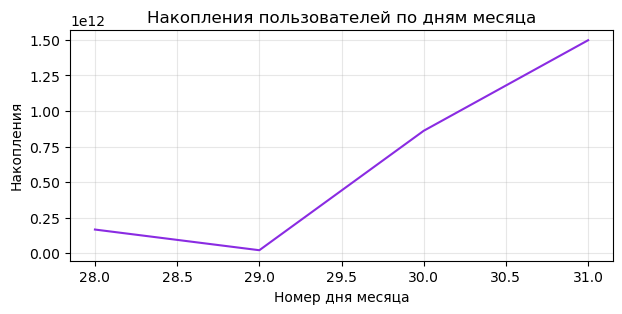

In [85]:
df.groupby('day')['VALUE'].sum().plot(figsize=(7, 3), color='blueviolet')
plt.xlabel('Номер дня месяца')
plt.ylabel('Накопления')
plt.title('Накопления пользователей по дням месяца')
plt.grid(axis='both', alpha=.3)

Данные по дням вероятно не совсем корректны, так как в изначальных данных присутствуют значения только пары дный в месяц.<br>
Однако по графику видно, что накопления постепенно снижаются к 29 чеслу каждого месяца и резко повышаются к 31. Это може быть связано с тем, что в конце месяца люди получают з/п и кладут ее на счет, а в течении месяца снимают какие-то суммы на свои расходы.

### Графики сезонности и тренда

In [88]:
decomposed = seasonal_decompose(data) 

**График тренда**

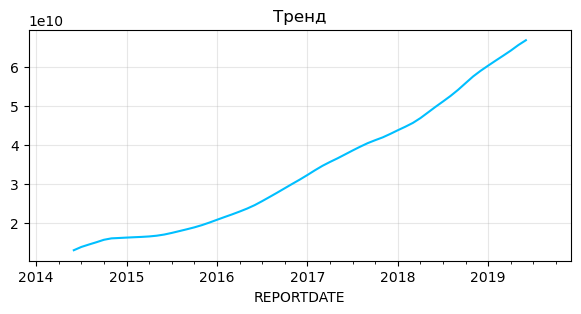

In [89]:
decomposed.trend.plot(ax=plt.gca(), figsize=(7, 3), color='deepskyblue')
plt.title('Тренд')
plt.grid(axis='both', alpha=.3)

Виден четкий тренд на возрастание с 2014 по 2019.

Посмотрим только 2018 год.

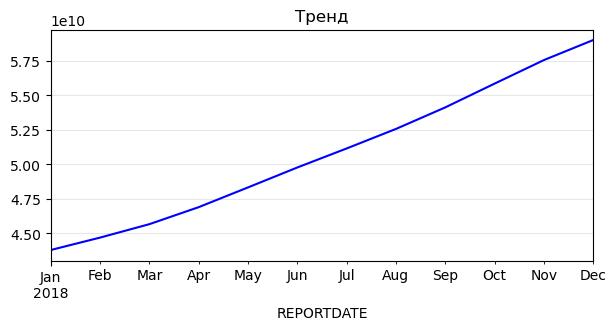

In [90]:
decomposed.trend['2018-01-01':'2018-12-31'].plot(ax=plt.gca(), figsize=(7, 3), color='blue')
plt.title('Тренд')
plt.grid(axis='both', alpha=.3)

Возрастание идет практически по прямой оси.

**График сезонности**

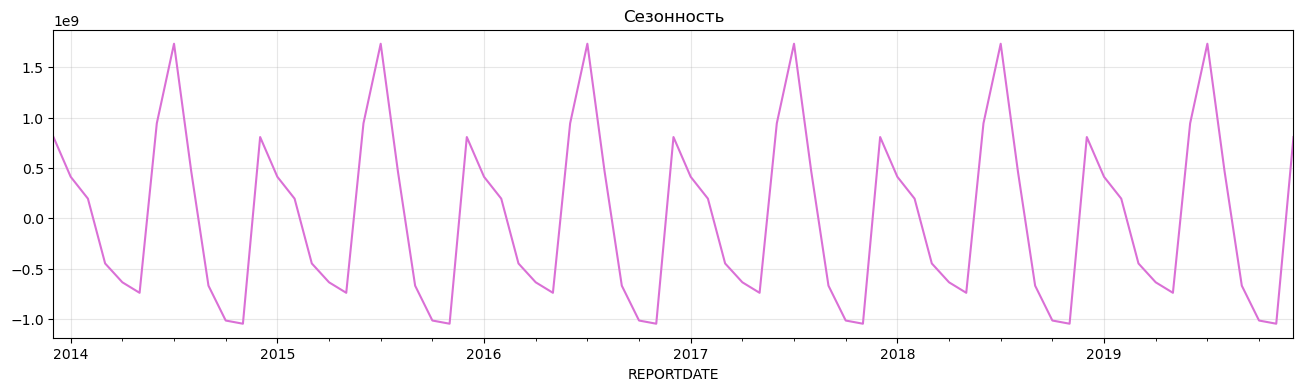

In [95]:
decomposed.seasonal.plot(ax=plt.gca(), figsize=(16, 4), color='orchid')
plt.title('Сезонность')
plt.grid(axis='both', alpha=.3)

Сезонность видна довольно четко. Одна рассмотрим график 2018 года для более подробного анализа.

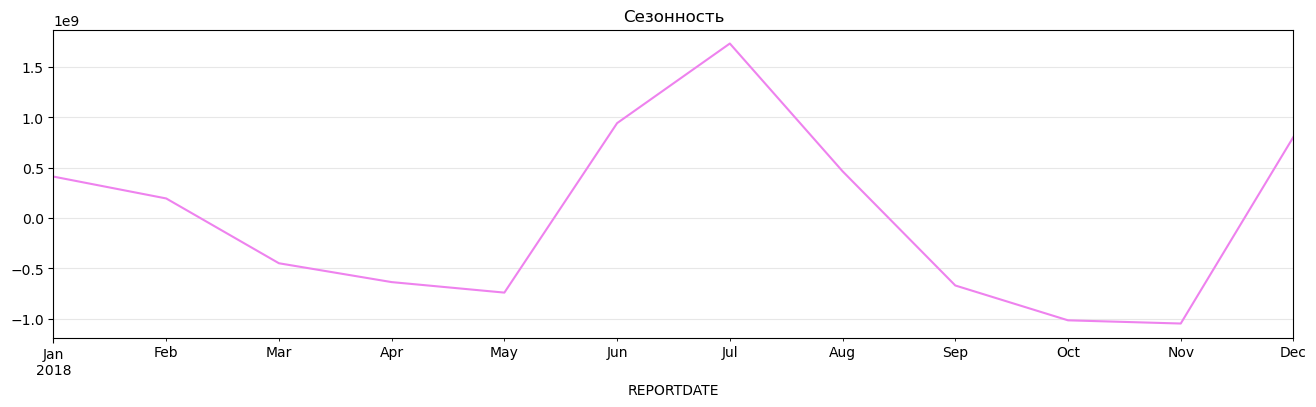

In [96]:
decomposed.seasonal['2018-01-01':'2018-12-31'].plot(ax=plt.gca(), figsize=(16, 4), color='violet')
plt.title('Сезонность')
plt.grid(axis='both', alpha=.3)

Анализируя графики, можем четко сказать, что количество накоплений зависит от месяца.

**График остатков**

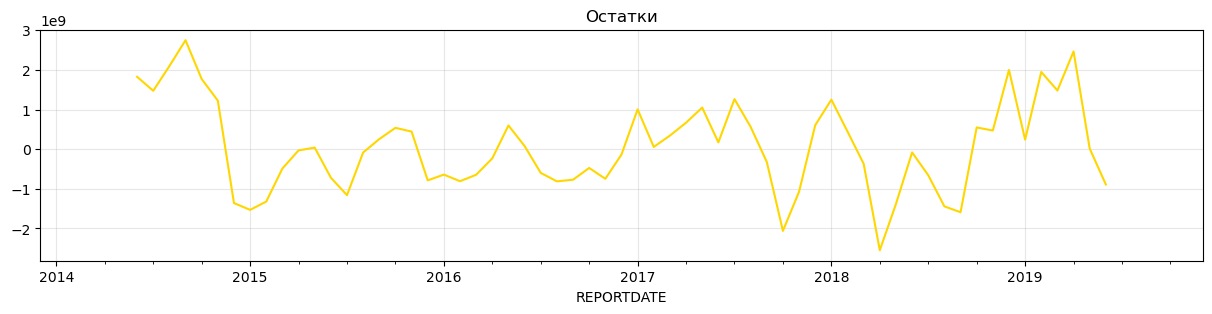

In [97]:
decomposed.resid.plot(ax=plt.gca(), figsize=(15, 3), color='gold')
plt.title('Остатки')
plt.grid(axis='both', alpha=.3)

График довольно скачущий, каких либо четких закономерностей в нем нет. Рассмотрим графики за 2017 и 2018 года.

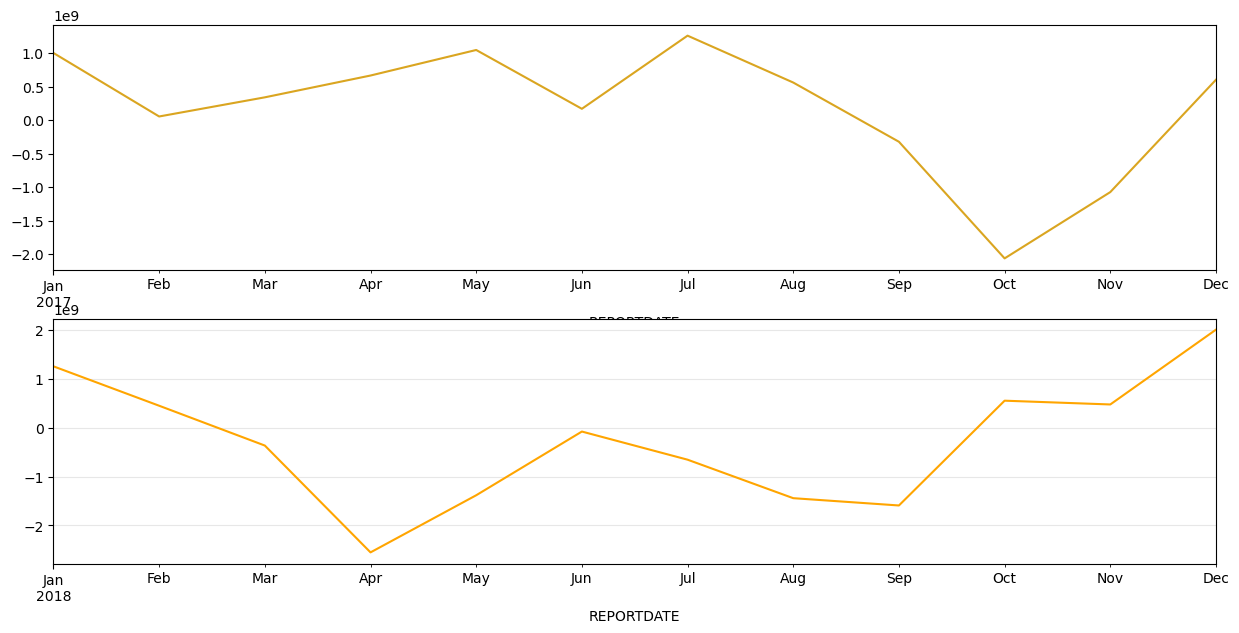

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 7))
decomposed.resid['2017-01-01':'2017-12-31'].plot(ax=ax[0], color='goldenrod')
decomposed.resid['2018-01-01':'2018-12-31'].plot(ax=ax[1], color='orange')
plt.grid(axis='both', alpha=.3)

Закономерностей опять же никаких нет.


Таким образом из графиков можно сказать:
- Тренд растет равномерно
- Имеется помесячная сезонность
- Количество накоплений заисит от дня недели, месяца и дня месяца

### Тест Дики-Фуллера

Построим временной ряд на разности с соседними значениями

In [104]:
result = adfuller(data['VALUE'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical values:')
for key, value in result[4].items():
  print('\t {}: {}'.format(key, value))

ADF Statistic: 2.316715951076296
p-value: 0.9989655580697495
Critical values:
	 1%: -3.53692771987915
	 5%: -2.907887369384766
	 10%: -2.591493291015625


p-value сильно больше порогового значения в 0.05, значит можно точно сказать, что ряд не стационарный.

**Вывод этапа:**
- Написана функция для создания датафрейма с разделенными признаками.
- Построены различные графики по индексам, из которых выяснили:
    * Количество накоплений возрастает в течении года
    * Резкое подение количества накоплений в понедельник и пятницу, и повышение накоплений к четвергу.
    * накопления постепенно снижаются к 29 чеслу каждого месяца и резко повышаются к 31. 
- Построены графики сезонности, из которых можно сказать:
    * Тренд растет равномерно
    * Имеется помесячная сезонность
- Проведен тест Дики-Фуллера, который однозначно доказал нестационарность ряда.

## Построение моделей 

Для обучения разделим данные на обучающую и тестовую выборки.

In [125]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['VALUE'], axis=1)
target_train = train['VALUE']
 
features_test = test.drop(['VALUE'], axis=1)
target_test = test['VALUE']

Проверим выборки.

In [126]:
display(train.shape)
display(test.shape)
print(train.index.min(), "  ",train.index.max())
print(test.index.min(), "  ", test.index.max())

(38, 35)

(5, 35)

2016-06-30 00:00:00    2019-07-31 00:00:00
2019-08-31 00:00:00    2019-12-31 00:00:00


Спрогнозируем модель по прошлому ряду.

In [154]:
pred_previous = np.ones(test.shape)*test.shift(fill_value = test.iloc[-1]['VALUE'])
print("RMSE:", round(np.sqrt(mse(test, pred_previous)),2))

RMSE: 14857228994.08


Создадим функцию для оценки модели и построения ее графиков

In [131]:
def model_evaluation(data, title):
    # Расчет метрик модели на тестовой выборке
    mae = mean_absolute_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index))
    mape = mean_absolute_percentage_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index))
    rmse = mean_squared_error(data['value'].tail(len(ts)-split_index), data['forecast'].tail(len(ts)-split_index), squared=False)
    # Рассчитываем пробитие на тестовой выборке
    data['penetration'] = data['forecast'].tail(len(ts)-split_index).min() - data['value'].tail(len(ts)-split_index)
    data['forecast_stable_part'] = data['forecast'].tail(len(ts)-split_index).min()
    data['real_stable_part'] = data['value'].tail(len(ts)-split_index).min()
    penetration = data.penetration[data.penetration > 0].sum()
    # Построение графиков прогноза
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(2,1, 1)
    ax2 = fig.add_subplot(2,1, 2)
    ## График модели на тренировочных данных
    data[['value','forecast']].head(split_index).plot(color=['black','green'], title='Модель '+title, grid=True, ax=ax1)      
    ax1.set(xlabel=None)
    ## График прогноза на тестовых данных
    data[['value','forecast', 'forecast_stable_part', 'real_stable_part']].tail(len(ts)-split_index).\
    plot(color=['black','red', 'orange', 'green'], title='Прогноз на тестовой выборке', grid=True, ax=ax2)
    ax2.set(xlabel=None)
    ax2.legend(loc='upper left')
    formatter = FuncFormatter(billions)
    ax1.yaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)
    plt.show()

    print(f'Значения метрик модели --> MAE - {np.round(mae)} | MAPE - {np.round(mape*100)}% | RMSE - {np.round(rmse)}')
    print(f'Объем пробития прогнозной стабильной части --> {penetration}')

### Линейная регрессия

In [155]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 123)
hyper_params = [{'n_features_to_select': list(range(1, 14))}]

In [156]:
%%time
lin = LinearRegression()
lin.fit(features_train, target_train)
rfe = RFE(lin)             
model = GridSearchCV(estimator = rfe, param_grid = hyper_params, scoring= 'neg_root_mean_squared_error', cv = folds, verbose = 1,
                        return_train_score=True)      

model.fit(features_train, target_train)

display(model.best_score_*-1)

Fitting 5 folds for each of 13 candidates, totalling 65 fits


1938227489.7536628

Wall time: 1.32 s


### CatBoostRegressor

In [157]:
tscv = TimeSeriesSplit(n_splits = 5)
common_cv_params = {'scoring': 'neg_root_mean_squared_error', 'return_train_score': True, 'cv': tscv}

In [158]:
%%time
params = {'max_depth': [4, 6, 8], 'learning_rate': [0.05, 0.1, 0.2]}
grid_ctb = GridSearchCV(CatBoostRegressor(loss_function='RMSE', random_state=123, verbose=False),
                       param_grid = params, n_jobs=-1, **common_cv_params)
grid_ctb.fit(features_train, target_train)

display(grid_ctb.best_score_*-1)

5191529102.804619

Wall time: 44.1 s


### SARIMA

Подберем параметры для модели SARIMAX из библиотеки statsmodel

In [152]:
params = pmdarima.auto_arima(df, exogenous=None, seasonal=True, stationary=False, m=30, information_criterion='aic', \
         max_order=12, max_p=3, max_q=3, max_P=3, max_Q=3, error_action='ignore')
print(f'Best parameters:\n(p, d, q): {params.order} and  (P, D, Q, s): {params.seasonal_order}')

Best parameters:
(p, d, q): (3, 0, 1) and  (P, D, Q, s): (2, 1, 0, 30)


Обучим модель

In [ ]:
sarima = smt.SARIMAX(train, order=(3,0,1), 
                     seasonal_order=(2,1,0,30), 
                     enforce_invertibility=False,
                     exog=None).fit()

In [200]:
df_srm_test = ts_test.to_frame(name='value')
df_srm_test['forecast'] = sarima.predict(start=len(ts_train), end=len(ts_train)+len(ts_test)-1, exog=None)

Поместим результаты и исходные данные в отдельный датафрейм для вывода графиков и метрик

In [201]:
df_srm_train = ts_train.to_frame(name='value')
df_srm_train['forecast'] = sarima.fittedvalues
df_srm = df_srm_train.append(df_srm_test)

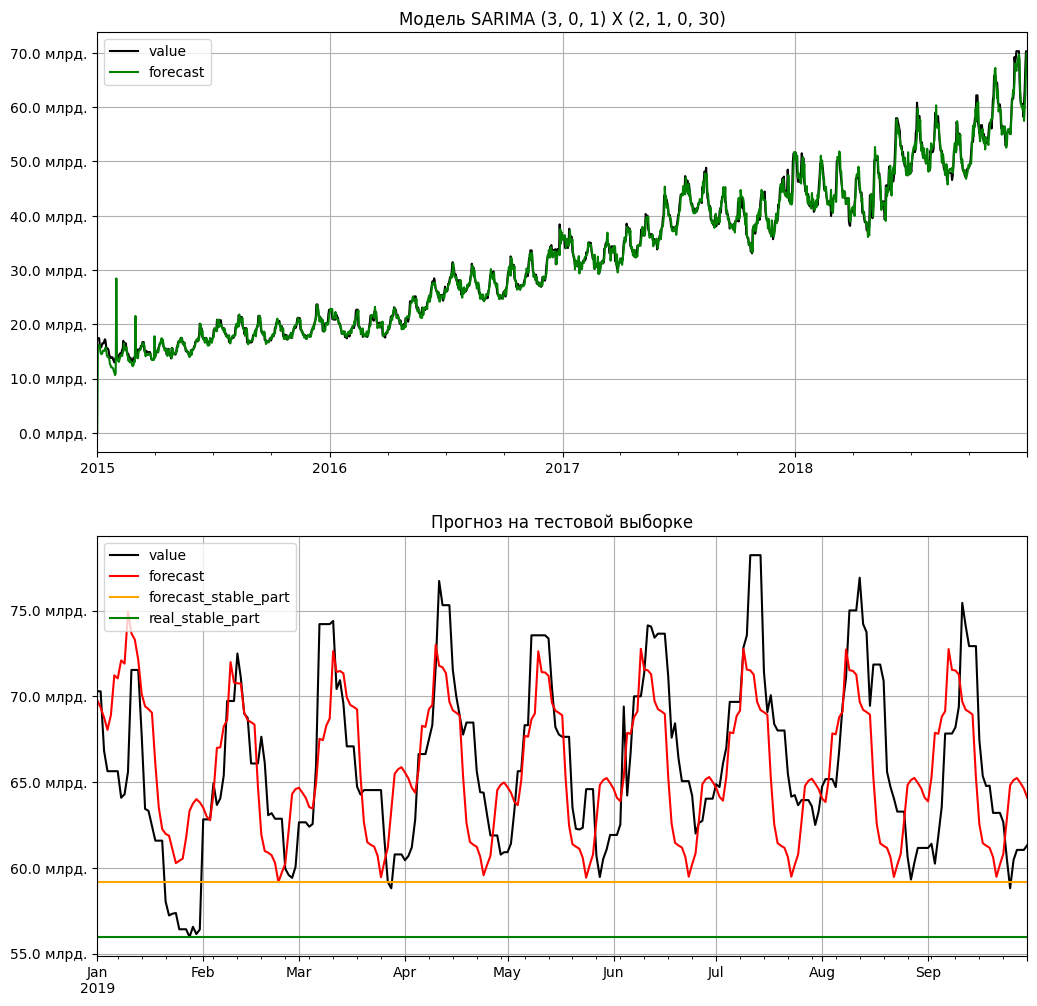

Значения метрик модели --> MAE - 3289422109.0 | MAPE - 5.0% | RMSE - 3934484021.0
Объем пробития прогнозной стабильной части --> 27263734184.089012


In [202]:
model_evaluation(df_srm, title='SARIMA (3, 0, 1) X (2, 1, 0, 30)')

Как видим, SARIMA показывает довольно высокую точность по метрикам. В целом качество предсказания модели можно считать высоким.

### Prophet

Подготовим тренировочные и тестовые данные

In [203]:
df_train = ts_train.reset_index().rename(columns={'REPORTDATE':'ds', 'VALUE':'y'})
df_test = ts_test.reset_index().rename(columns={'REPORTDATE':'ds', 'VALUE':'y'})

Обучим модель

In [204]:
prophet = Prophet(growth='linear', changepoints=None, 
                  n_changepoints=365,
                  seasonality_mode='multiplicative',
                  yearly_seasonality='auto', 
                  weekly_seasonality='auto', 
                  daily_seasonality=False,
                  holidays=None)
prophet.add_country_holidays(country_name='RU')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=3)

prophet.fit(df_train)

13:16:16 - cmdstanpy - INFO - Chain [1] start processing
13:16:18 - cmdstanpy - INFO - Chain [1] done processing


In [205]:
df_prophet = prophet.make_future_dataframe(periods=len(df_test), freq='D', include_history=True)
df_prophet = prophet.predict(df_prophet)

Поместим результаты в отдельный датафрейм

In [206]:
df_prt_train = df_train.merge(df_prophet[['ds','yhat']], how='left').\
               rename(columns={'yhat':'forecast', 'y':'value'}).set_index('ds')
df_prt_test = df_test.merge(df_prophet[['ds','yhat']], how='left').\
              rename(columns={'yhat':'forecast', 'y':'value'}).set_index('ds')
df_prophet_unit = df_prt_train.append(df_prt_test)

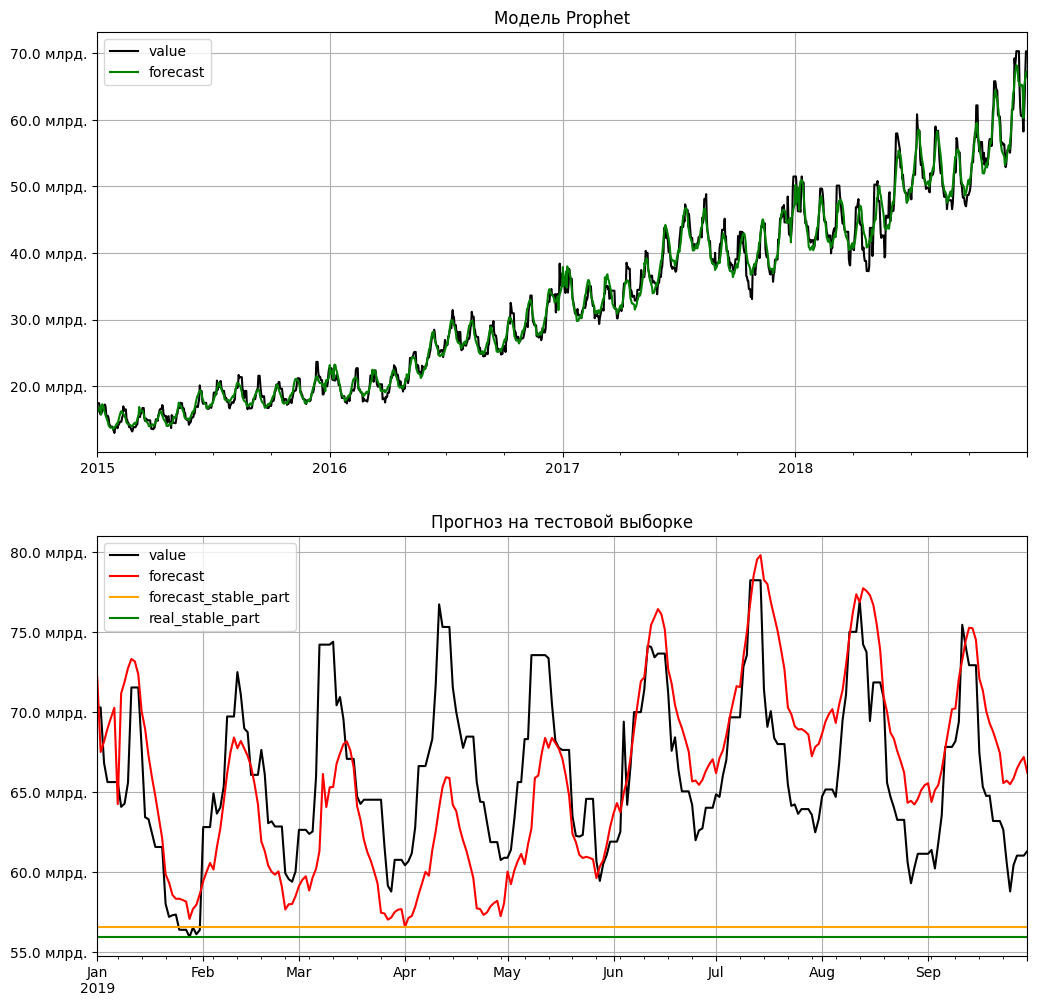

Значения метрик модели --> MAE - 3594000077.0 | MAPE - 5.0% | RMSE - 4342594487.0
Объем пробития прогнозной стабильной части --> 1805276764.518982


In [207]:
model_evaluation(df_prophet_unit, title='Prophet')

Из всех данных четко видим, что SARIMA показывает наилучшие знчения, поэтому для дальнейших прогнозов выберем именно эту модель.

**Вывод этапа:**
- Проведено разделение данных на тестовую и тренировочную выборки.
- Обучены модели и получены значения метрики RMSE.
- Лучшей моделью выбпана SARIMA

## Построение функции для прогнозирования стабильной части для заданной даты и горизонта

Создадим функцию для прогноза объема стабильной части средств с заданным горизонтом n месяцев от указанной даты.

In [430]:
def prediction(hist_data, start_date, horizon, fault):
    start_date = pd.to_datetime(start_date)
    last_date = start_date + relativedelta(months=int(horizon[:-1]))
    split_index = hist_data[hist_data.loc[:,'REPORTDATE']==start_date].index[0]
    ts_hist = hist_data.set_index('REPORTDATE').squeeze().rename('VALUE').head(split_index)
    df_test = pd.DataFrame(pd.date_range(start_date, last_date), columns=['REPORTDATE'])

    sarima = smt.SARIMAX(ts_hist, order=(3,0,1), 
                         seasonal_order=(2,1,0,30), 
                         enforce_invertibility=False,
                         exog=None).fit()
    predict = sarima.predict(start=len(ts_hist), end=len(ts_hist)+len(df_test)-1, exog=None)

    stable_part=round(min(predict), 2)
    print(f'Стабильная часть средств на дату {str(start_date)[:10]} с горизонтом\
    {int(horizon[:-1])} месяц(-а,-ев) - {stable_part}')
    # Расчет объема пробития, если указанный интервал start_data + N месяцев находится в пределах исторических данных, а также 
    # разницы между фактической и модельной стабильной частью
    if (fault == True) and ((hist_data.loc[len(hist_data) - 1, 'REPORTDATE'] - last_date).days >= 0):
        df_test['forecast'] = predict.tolist()
        df_test = pd.merge(left=hist_data, right=df_test, on='REPORTDATE', how='inner') 
        df_test['penetration'] = df_test['forecast'].min() - df_test['VALUE']
        penetration = round(df_test.penetration[df_test.penetration > 0].sum(), 2)
        print(f'Объем пробития стабильной части - {penetration}')
        delta = round(df_test['VALUE'].min() - df_test['forecast'].min(), 2)
        print(f'Дельта между фактической и модельной стабильной частью - {delta if delta > 0 else 0}') 
    elif (fault == True) and ((hist_data.loc[len(hist_data) - 1, 'REPORTDATE'] - last_date).days < 0):
        print('Объем пробития стабильной части и дельта между фактической и модельной стабильной частью неизвестны.')
        print('Прогноз вне диапазона исторических данных.')
    else:
        None

Проверим модель на различных датах и горизонтах 

In [413]:
prediction(df, start_date='2019-03-01', horizon='3M', fault=True)

Стабильная часть средств на дату 2019-03-01 с горизонтом 3 месяц(-а,-ев) - 58789617340.9
Объем пробития стабильной части - 0.0
Дельта между фактической и модельной стабильной частью - 10463706.1


In [414]:
prediction(df, start_date='2019-01-01', horizon='6M', fault=True)

Стабильная часть средств на дату 2019-01-01 с горизонтом 6 месяц(-а,-ев) - 59163178931.93
Объем пробития стабильной части - 26906849640.16
Дельта между фактической и модельной стабильной частью - 0


In [415]:
prediction(df, start_date='2019-06-01', horizon='1M', fault=True)

Стабильная часть средств на дату 2019-06-01 с горизонтом 1 месяц(-а,-ев) - 60654391991.0
Объем пробития стабильной части - 0.0
Дельта между фактической и модельной стабильной частью - 1260554309.0


In [431]:
prediction(df, start_date='2019-05-01', horizon='12M', fault=True)

Стабильная часть средств на дату 2019-05-01 с горизонтом    12 месяц(-а,-ев) - 60277681466.69
Объем пробития стабильной части и дельта между фактической и модельной стабильной частью неизвестны.
Прогноз вне диапазона исторических данных.


In [423]:
prediction(df, start_date='2019-04-01', horizon='9M', fault=False)

Стабильная часть средств на дату 2019-04-01 с горизонтом 9 месяц(-а,-ев) - 58195204569.75


## Вывод

Итак, нам предоставлены данные компании о накоплениях клиента банка. Чтобы иметь представление о количестве стабильныз средтсв у банка, нужно построить модель с предсказанием.

На этапе подготовки были загружены данные, исправлен тип данных даты, проведена проверка на пропуски и дубликаты в данных (не обнаружено) и проведено ресемплирование данных на месячные интервалы

На этапе анализа написана функция для создания датафрейма с разделенными признаками.<br>
Построены различные графики по индексам, из которых выяснили:
- Количество накоплений возрастает в течении года
- Резкое подение количества накоплений в понедельник и пятницу, и повышение накоплений к четвергу.
- накопления постепенно снижаются к 29 чеслу каждого месяца и резко повышаются к 31.

Построены графики сезонности, из которых можно сказать:
- Тренд растет равномерно
- Имеется помесячная сезонность

Проведен тест Дики-Фуллера, который однозначно доказал нестационарность ряда.

Для дальнейшего обучения проведено разделение данных на тестовую и тренировочную выборки. Обучены модели, среди которых лучшей себя показала SARIMS, и получены значения метрики RMSE.

На основе выбранной модели написана функция для прогнозирования стабильной части для заданной даты и горизонта, где расчет объема пробития, если указанный интервал start_data + N месяцев находится в пределах исторических данных, а также разницы между фактической и модельной стабильной частью.